In [13]:
import numpy as np
import pandas as pd
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise


def FilterSnowdepthFilterPy(sensor_number, obs_noise, process_noise):
    
    df = pd.read_pickle('../output/cluster_0_cleaned.pickle')
    
    # Label the state parameters. 
    state_params=['depth_1', 'velocity_1' ,'baseline_1']
    
    # Observations 
    Y = df['snowdepth_%i'%sensor_number].values
    
    # Let's estimate the initial baseline using the median of the first 2500 data points, excluding NaNs
    baseline = np.median(Y[:2500][~np.isnan(Y[:2500])])
    
    # First observation that is not nan 
    Y0 = Y[np.argwhere(~np.isnan(Y))[0]]
    dt = .25  # 15 minute intervals so velcoity is in mm/hr

    # Now setup the kalman filter model
    f = KalmanFilter(dim_x=3, dim_z=1)
    f.x = np.array([-Y0+baseline, 0., baseline])# Initial state means 
    f.P = sigma_0 = np.diag((50, 10, 10))        # Initial state covariance 
    # State transition Matrix 
    f.F = np.array([[1, dt, 0],
                    [0,  1, 0],
                    [0,  0, 1]])
    # Measurement Function 
    f.H = np.array([[-1, 0, 1],]) 
    # Process noise 
    #f.Q = Q_discrete_white_noise(2, 1, 1e-8)

    f.Q = process_noise
    

    # Observation Noise 
    f.R = obs_noise
    # Control Transition Model is zero by defult
    
    
    mu_list = np.zeros((len(Y),len(f.x)))
    sigma = np.zeros(len(Y))
    
    for i_obs in range(len(Y)-1):
        f.predict()
        if not np.isnan(Y[i_obs]):
            f.update(Y[i_obs])
        mu_list[i_obs] = f.x
        sigma[i_obs] = np.dot(np.dot(f.H,f.P),f.H.T)
        
    return Y, mu_list, sigma


In [14]:
Y, mu, S = FilterSnowdepthFilterPy(sensor_number=1, obs_noise=50, process_noise=np.diag([1e-4, 1e-4, 1e-4]))




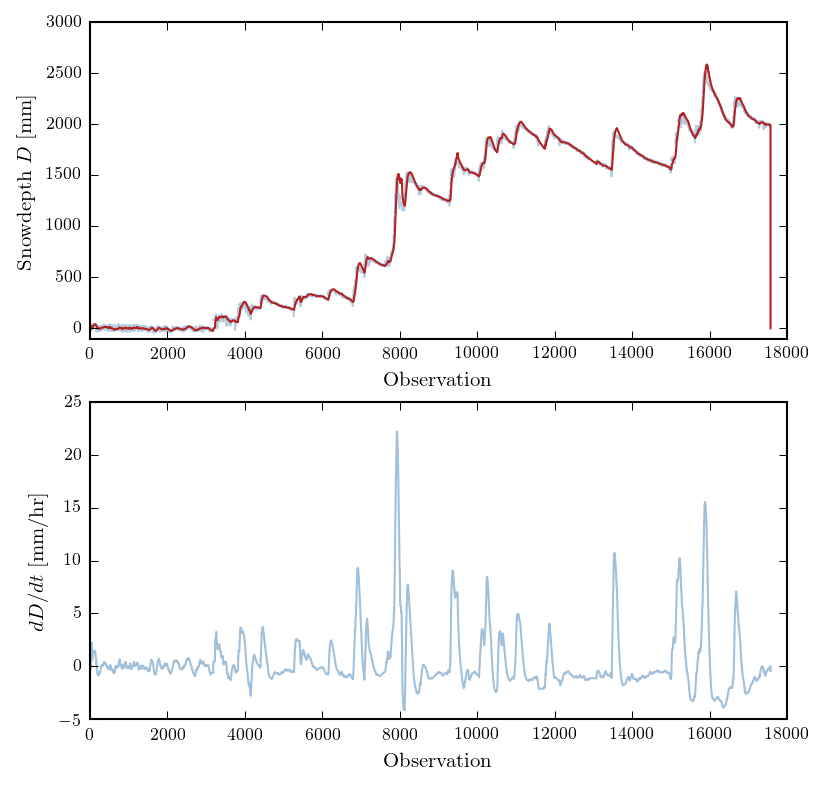

In [31]:

plt.figure(figsize=(6,6))

# Plot the Snowdepth 
plt.subplot(211)
plt.plot(-Y+mu[:,2], alpha=.4) 
plt.plot(mu[:,0])

plt.ylim(-1e2,3e3)
plt.xlabel('Observation')
plt.ylabel('Snowdepth $D$ [mm]')



plt.subplot(212)
plt.plot(mu[:,1], alpha=.5, color='steelblue')
plt.xlabel('Observation')
plt.ylabel('$dD/dt$ [mm/hr]')
#plt.ylim(-200, 3e3)


